In [2]:
# Import the necessary libraries

import pandas as pd

import os

import numpy as np

import tensorflow as tf

import matplotlib.pyplot as plt

import seaborn as sns

from keras.models import Sequential

from keras.preprocessing.image import ImageDataGenerator

from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

from tensorflow.keras.applications import ResNet50V2

from tensorflow.keras.layers import Dense, Flatten, Dropout, MaxPooling2D

from tensorflow.keras.models import Sequential

from tensorflow.keras.callbacks import EarlyStopping

from tensorflow.keras.layers import GlobalAveragePooling2D

from tensorflow.keras.models import Model

from tensorflow.keras.optimizers import Adam

from keras.preprocessing import image

from keras.applications.mobilenet_v2 import preprocess_input, decode_predictions

from keras.models import load_model

from keras.preprocessing import image

from keras.applications.mobilenet_v2 import preprocess_input, decode_predictions

from keras.models import load_model

from sklearn.metrics import f1_score

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from sklearn.metrics import classification_report

In [3]:
data = 'sports.csv'
df = pd.read_csv(data)

In [4]:
class_names = sorted(df['labels'].unique())
num_classes = len(class_names)
class_to_index = {class_name: index for index, class_name in enumerate(class_names)}
df['label_index'] = df['labels'].map(class_to_index)

In [5]:
img_height, img_width = 256, 256
datagen = ImageDataGenerator(rescale=1./256)

In [6]:
# Train-Test-Validation Split

train_df = df[df['data set'] == 'train']
test_df = df[df['data set'] == 'test']
val_df = df[df['data set'] == 'valid']

# Create Data Generators

train_data_gen = datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='filepaths',
    y_col='label_index',
    target_size=(img_height, img_width),
    batch_size=64,
    class_mode='raw',
    shuffle=True
)

test_data_gen = datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='filepaths',
    y_col='label_index',
    target_size=(img_height, img_width),
    batch_size=64,
    class_mode='raw',
    shuffle=False
)

val_data_gen = datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col='filepaths',
    y_col='label_index',
    target_size=(img_height, img_width),
    batch_size=64,
    class_mode='raw',
    shuffle=False
)

Found 13492 validated image filenames.
Found 500 validated image filenames.
Found 500 validated image filenames.


c:\Python\lib\site-packages\keras\src\preprocessing\image.py:1137: UserWarning: Found 1 invalid image filename(s) in x_col="filepaths". These filename(s) will be ignored.
  warnings.warn(


In [ ]:
# Define a function that calculates the F1-Score

def f1_score_metric(y_true, y_pred):
    y_pred = tf.argmax(y_pred, axis=-1)
    f1_per_class = []
    for class_id in range(100):
        class_true = tf.cast(tf.equal(y_true, class_id), tf.float32)
        class_pred = tf.cast(tf.equal(y_pred, class_id), tf.float32)
        f1 = tf.py_function(lambda y_true, y_pred: f1_score(y_true, y_pred, zero_division=1), (class_true, class_pred), tf.float32)
        f1_per_class.append(f1)
    return tf.reduce_mean(f1_per_class)

# Resnet50V2 Model

resnet = ResNet50V2(
    input_shape=(256, 256, 3), include_top=False, weights="imagenet", classes=100
)
resnet.trainable = False

model = Sequential()
model.add(resnet)
model.add(Flatten())
model.add(Dropout(0.1))
model.add(Dense(256, activation="leaky_relu"))
model.add(Dropout(0.1))
model.add(Dense(128, activation="leaky_relu"))
model.add(Dropout(0.1))
model.add(Dense(100, activation="softmax"))

model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy", f1_score_metric]
)

model.summary()

history = model.fit(
    train_data_gen,
    epochs=5,
    batch_size=128,
    validation_data=val_data_gen,
    verbose=1,
)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 8, 8, 2048)        23564800  
                                                                 
 flatten (Flatten)           (None, 131072)            0         
                                                                 
 dropout (Dropout)           (None, 131072)            0         
                                                                 
 dense (Dense)               (None, 256)               33554688  
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dropout_2 (Dropout)         (None, 128)               0

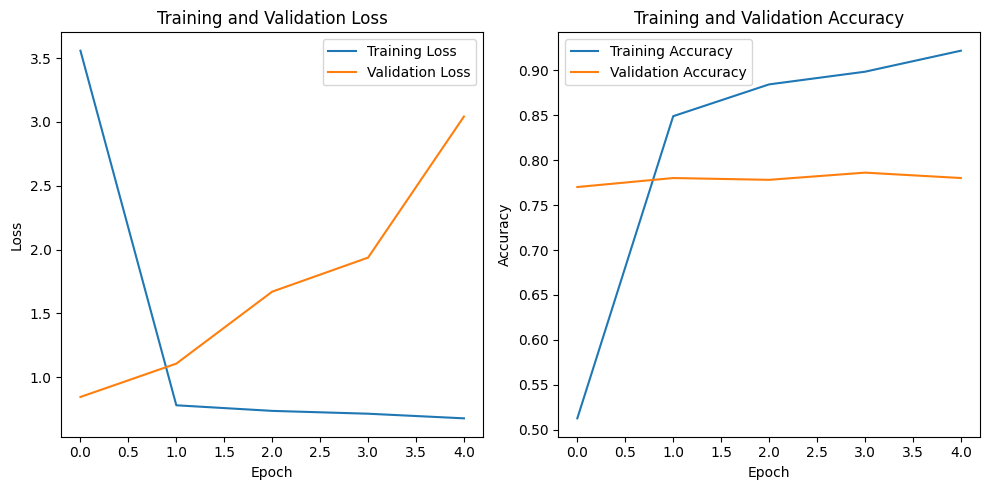

In [ ]:
# Plot training and validation loss

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plot training and validation accuracy

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Resnet50V2 fine tuning

base_model = ResNet50V2(
    input_shape=(256, 256, 3), include_top=False, weights="imagenet"
)

for layer in base_model.layers:
    layer.trainable = False

x = GlobalAveragePooling2D()(base_model.output)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(num_classes, activation='softmax')(x)

fine_tuned_model = Model(inputs=base_model.input, outputs=output)

fine_tuned_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy', f1_score_metric])

history_fine_tuned = fine_tuned_model.fit(
    train_data_gen,
    epochs=5,
    batch_size=32,
    validation_data=val_data_gen,
)

Epoch 1/5
211/211 [==============================] - 497s 2s/step - loss: 2.3057 - accuracy: 0.4367 - f1_score_metric: 0.5827 - val_loss: 0.6826 - val_accuracy: 0.8200 - val_f1_score_metric: 0.9041
Epoch 2/5
211/211 [==============================] - 470s 2s/step - loss: 0.9694 - accuracy: 0.7261 - f1_score_metric: 0.7809 - val_loss: 0.4241 - val_accuracy: 0.8840 - val_f1_score_metric: 0.9427
Epoch 3/5
211/211 [==============================] - 458s 2s/step - loss: 0.6938 - accuracy: 0.7937 - f1_score_metric: 0.8332 - val_loss: 0.3166 - val_accuracy: 0.8960 - val_f1_score_metric: 0.9512
Epoch 4/5
211/211 [==============================] - 453s 2s/step - loss: 0.5452 - accuracy: 0.8329 - f1_score_metric: 0.8646 - val_loss: 0.2685 - val_accuracy: 0.9120 - val_f1_score_metric: 0.9495
Epoch 5/5
211/211 [==============================] - 472s 2s/step - loss: 0.4578 - accuracy: 0.8587 - f1_score_metric: 0.8831 - val_loss: 0.2576 - val_accuracy: 0.9240 - val_f1_score_metric: 0.9589


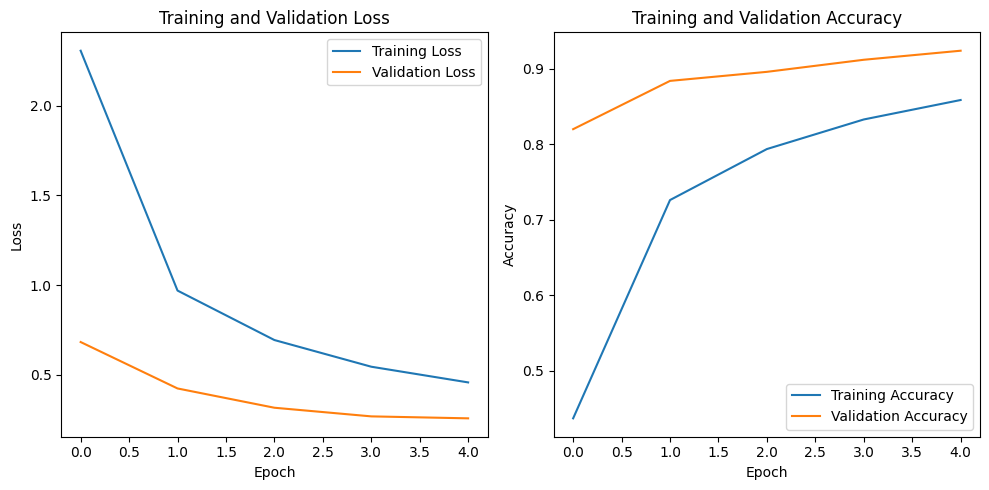

In [ ]:
# Plot training and validation loss

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(history_fine_tuned.history['loss'], label='Training Loss')
plt.plot(history_fine_tuned.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plot training and validation accuracy

plt.subplot(1, 2, 2)
plt.plot(history_fine_tuned.history['accuracy'], label='Training Accuracy')
plt.plot(history_fine_tuned.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
fine_tuned_model.save("ResNetFINETUNED.h5")

C:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 89ms/step


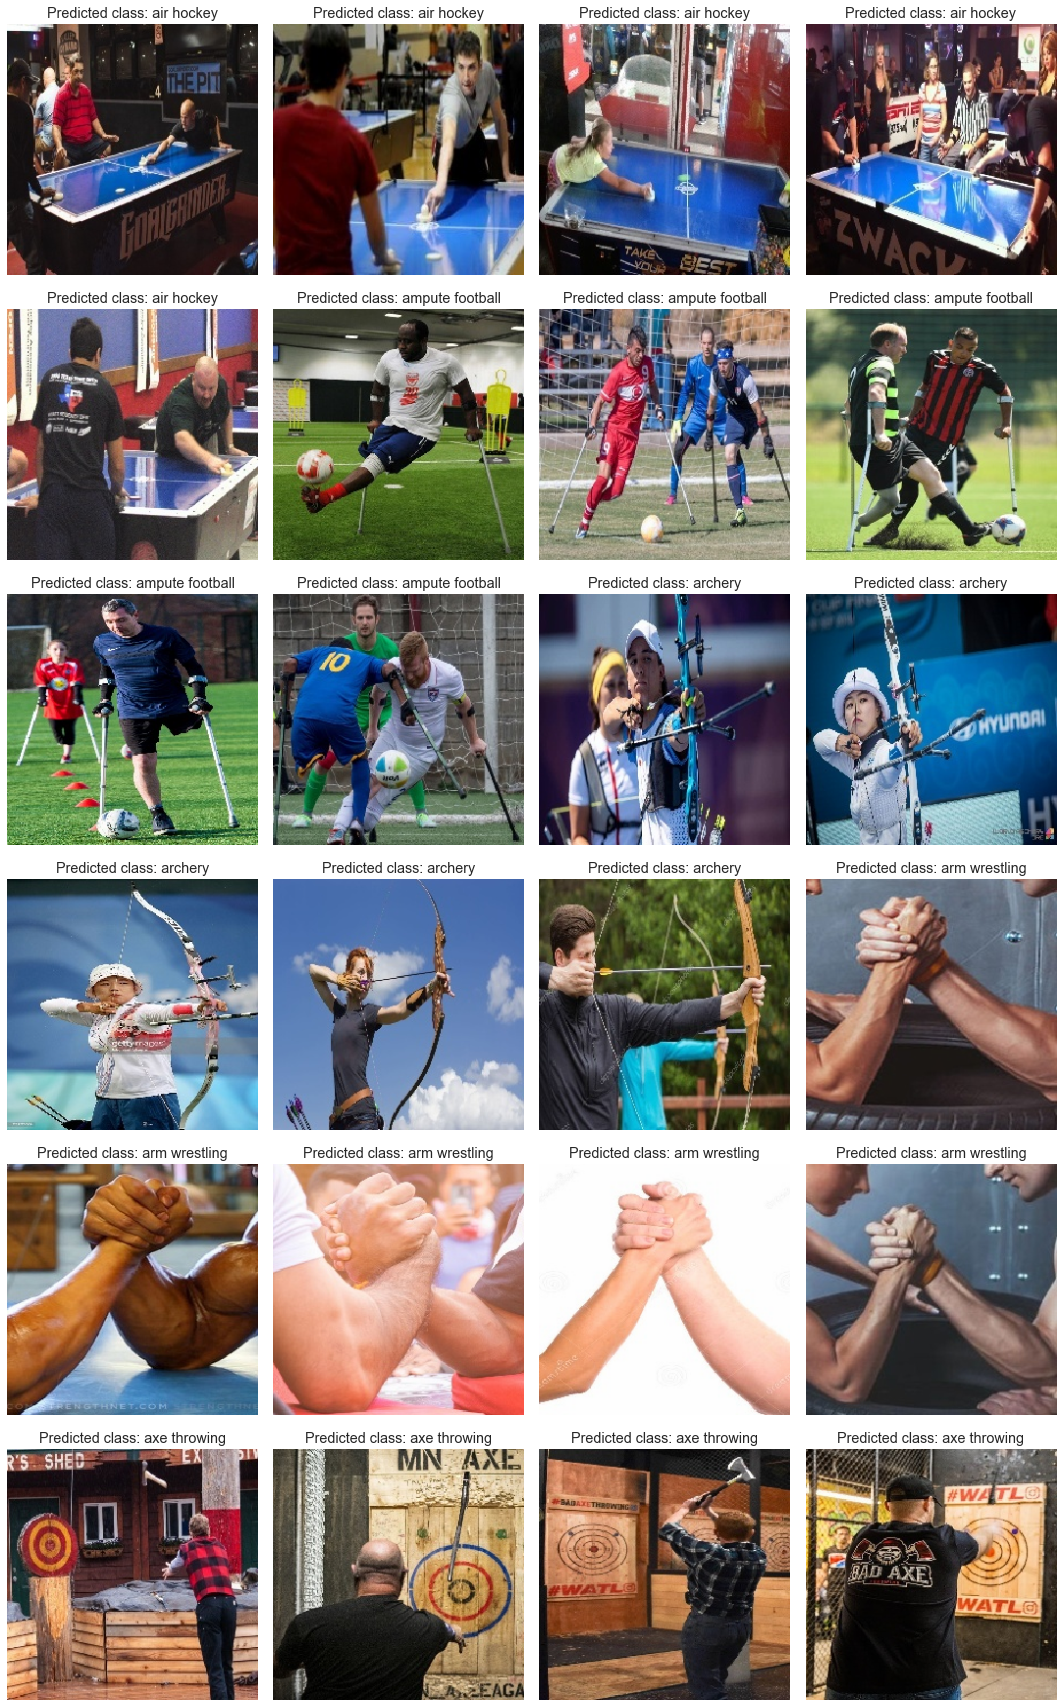

In [12]:
model = load_model("ResNetFINETUNED.h5", custom_objects={'f1_score_metric': f1_score_metric})

# Access the first batch from the validation data generator

batch_images, batch_labels = next(val_data_gen)

# Make predictions on the entire batch

batch_predictions = model.predict(batch_images)

# Get the index of the predicted class

predicted_class_index = np.argmax(batch_predictions, axis=1)

# Create a subplot for displaying images

num_images = 24  # Specify the number of images to display
num_rows = (num_images + 3) // 4  # 4 images per row
fig, axs = plt.subplots(num_rows, 4, figsize=(15, 4 * num_rows))

# Iterate through the specified number of images and display them

for i in range(num_images):
    row_idx = i // 4
    col_idx = i % 4

    # Access the image from the batch

    selected_image = batch_images[i]

    # Resize the image to (256, 256)

    resized_image = image.smart_resize(selected_image, (256, 256))

    # Preprocess the resized image for model prediction

    preprocessed_image = preprocess_input(resized_image)

    # Make predictions

    predictions = model.predict(np.expand_dims(preprocessed_image, axis=0))

    # Get the corresponding class label from the class_names list

    predicted_class_label = class_names[predicted_class_index[i]]

    # Display the selected image

    axs[row_idx, col_idx].imshow(selected_image)
    axs[row_idx, col_idx].set_title(f"Predicted class: {predicted_class_label}")
    axs[row_idx, col_idx].axis('off')

# Remove any empty subplots

for i in range(num_images, num_rows * 4):
    row_idx = i // 4
    col_idx = i % 4
    axs[row_idx, col_idx].axis('off')

plt.tight_layout()
plt.show()

8/8 [==============================] - 23s 3s/step
                       precision    recall  f1-score   support

           air hockey       1.00      1.00      1.00         5
      ampute football       0.83      1.00      0.91         5
              archery       1.00      1.00      1.00         5
        arm wrestling       1.00      1.00      1.00         5
         axe throwing       1.00      1.00      1.00         5
         balance beam       1.00      0.80      0.89         5
        barell racing       1.00      1.00      1.00         5
             baseball       0.71      1.00      0.83         5
           basketball       0.80      0.80      0.80         5
       baton twirling       1.00      0.80      0.89         5
            bike polo       1.00      1.00      1.00         5
            billiards       1.00      1.00      1.00         5
                  bmx       1.00      0.80      0.89         5
              bobsled       1.00      0.80      0.89         5
   

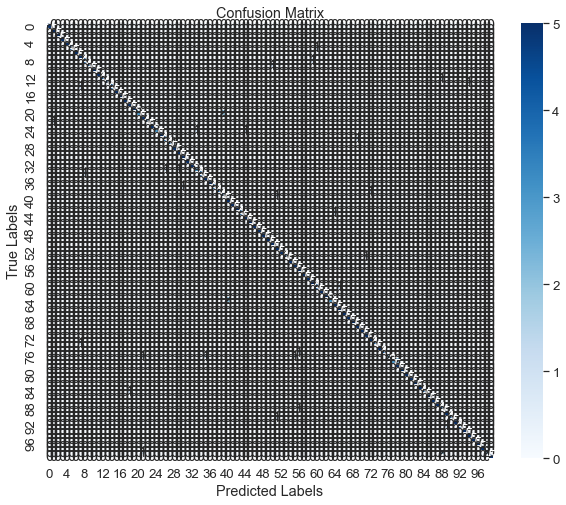

In [13]:
model = load_model("ResNetFINETUNED.h5", custom_objects={'f1_score_metric': f1_score_metric})

y_pred = model.predict(val_data_gen)

y_true = val_data_gen.labels

# Create a confusion matrix

cm = confusion_matrix(y_true, np.argmax(y_pred, axis=-1))

# Create a heatmap for the confusion matrix

plt.figure(figsize=(10, 8))
sns.set(font_scale=1.2)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')

plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')

print(classification_report(y_true, np.argmax(y_pred, axis=-1), target_names=class_names))

plt.show()
